In [ ]:
import gibbs_mcmc_nn as mc #imports the file with all the functions of the Gibbs sampler
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.set_default_tensor_type(torch.FloatTensor) 

cuda


# Introduction
In this notebook we will use the Gibbs sampler to sample form the posterior of a neural network, in the case where the training set is MNIST.



The algorithm is described in detail in the paper **Gibbs Sampling the Posterior of Neural Networks**.




## Architecture

Let's start by defining the neural network's architecture and the posterior that we wish to sample. We will focus on a neural net with input dimension $d^{(1)}=28\times 28$, $d^{(2)}=12$ hidden units and $d^{(3)}=10$ output units (corresponding to th 10 possible labels), over which we take an argmax. We use ReLU activations. The neural network function is $f(\cdot,W):\mathbb R^d\mapsto \mathbb R$,
\begin{equation}
f(x,W)=\arg\max_{c\in\{0,1,\dots,9\}} b^{(2)}_c+\sum_{\alpha=1}^{d^{(2)}}W^{(2)}_{c\alpha} \sigma\left(W^{(1)T}_\alpha x+b^{(1)}_\alpha\right)
\end{equation}
with the weight matrices $W^{(1)}\in\mathbb R^{d_2 \times d_1}$, $W^{(2)}\in\mathbb R^{C \times d_2}$, $b^{(1)}\in\mathbb R^{d_2}$, $b^{(2)}\in\mathbb R^{C}$. The input vector $x$ lives in $\mathbb R^{d_1}$ and $\sigma(x)=\max(0,x)$.



In [ ]:
def MLP_class_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X):
    return torch.argmax((sigma(X@(W_1.T)+b_1[None,:]))@(W_2.T)+b_2[None,:],axis=1).type(torch.long)

## Posterior
Let $X\in\mathbb R^{n\times d_1}$ be our training inputs and $y\in\mathbb R^n$ the training labels. $n$ is the size of the training set.

We want to sample from the posterior
\begin{equation}
P(W|X,y)=\frac{P(y|X,W)P(W)}{P(y|X)},
\end{equation}
where $W$ indicates all the parameters of the network.
Given an architecture $f$ there are several ways to translate it inot a posterior. The Gibbs sampler allows to sample one of these forms, named the intermediate noise posterior.
Define $Z^{(2)}\in\mathbb R^{n\times d_2}, X^{(2)}\in\mathbb R^{n\times d_2}$ to respectively the pre- and post- activations of the first layer.
We will draw samples from the probability.
\begin{align}
&P(W,Z^{(2)},X^{(2)}|X,y)=\frac{1}{\mathcal Z}\left\{\prod_{\mu=1}^n\mathbb{I}\left[y^\mu=\arg\max_{c\in\{0,\dots,9\}}Z^{(3)\mu}_{c}\right]\right\}\times\\&\exp\left\{-\frac{1}{2\Delta}\left[\sum_{\mu=1}^{n}\sum_{c=0}^{9}\left(Z^{(3)\mu}_{c}-W_{c}^{(2)T}X^{(2)\mu}\right)^2+\sum_{\mu=1}^{n}\sum_{\alpha=1}^{d_2}\left(X^{(2)\mu}_\alpha-\sigma(Z^{(2)\mu}_\alpha)\right)^2+\left(Z^{(2)\mu}_\alpha-W_\alpha^{(1)T}X^\mu\right)^2\right]\right\}\times\\&\times\exp\left[-\frac{\lambda_W^{(1)}}{2}\sum_{\alpha=1}^{d_2}\sum_{i=1}^{d_1}(W^{(1)}_{\alpha i})^2-\frac{\lambda_b^{(1)}}{2}\sum_{\alpha=1}^{d_2}(b^{(1)}_{\alpha})^2-\frac{\lambda_W^{(2)}}{2}\sum_{\alpha=1}^{d_2}\sum_{c=0}^{9}(W^{(2)}_{c\alpha})^2-\frac{\lambda_b^{(2)}}{2} \sum_{c=0}^9(b^{(2)}_c)^2\right]
\end{align}

$\Delta$ is a *temperature* parameter for the Gibbs sampler.
We place a i.i.d. gaussian prior on each weight vector. $\lambda_W^{(1)},\lambda_b^{(1)},\lambda_W^{(2)},\lambda_b^{(2)}$ are the inverse variances of the prior of respectively the first layer weights and biases and second layer weights and bias.


The Gibbs sampler draws samples from this posterior by iteratively sampling each of $W^{(1)},b^{(1)},Z^{(2)},X^{(2)},W^{(2)},b^{(2)}, Z^{(3)}$ from its conditional distribution on all other variables.





## Dataset loading
We load the MNIST dataset from the file `mnist.npz` downloadable at https://www.kaggle.com/datasets/vikramtiwari/mnist-numpy .


In [ ]:
n=60000 #number of training points
n_test=5000 #number of test points
file_mnist=np.load("./mnist.npz",allow_pickle=True)
X_train=torch.tensor(file_mnist["x_train"]) #use only half of the training set
X_test=torch.tensor(file_mnist['x_test']) #use only half of the test set
y_train=torch.tensor(file_mnist['y_train']).type(torch.long).flatten()[:n]
y_test=torch.tensor(file_mnist['y_test']).type(torch.long).flatten()[:n_test]


#normalizing training and test inputs
X_train=X_train.reshape([60000,28*28])[:n]/255
X_test=X_test.reshape([10000,28*28])[:n_test]/255
mean_X=torch.mean(X_train)
std_X=torch.std(X_train)
X_train=(X_train-mean_X)/std_X
X_test=(X_test-mean_X)/std_X

## Gibbs parameters

We will now run the Gibbs sampler on the dataset. 
First we must set the algorithm's parameters, i.e., $\Delta,\lambda_W^{(1)},\lambda_W^{(1)},\lambda_W^{(2)}, \lambda_b^{(2)}$. We take $\lambda_W^{(1)}=\lambda_b^{(1)}=d_1=784,\;\lambda_w^{(2)}=\lambda_b^{(2)}=d_2=12$

In [ ]:
sigma=torch.nn.ReLU()
d_1=torch.tensor(28*28)
d_2=torch.tensor(12)
C=10 #number of classes
lambda_W_1=d_1
lambda_b_1=d_1
lambda_W_2=d_2
lambda_b_2=d_2
Delta=torch.tensor(2) #temperature of the posterior

## Initialization
for the Gibbs sampler we set all variables initially to zero.


In [ ]:
#zero initialization
W_1=torch.zeros(size=[d_2,d_1])
b_1=torch.zeros(size=[d_2])
Z_2=torch.zeros(size=[n,d_2])
X_2=torch.zeros(size=[n,d_2])
W_2=torch.zeros(size=[C,d_2])
b_2=torch.zeros(size=[C])
Z_3=torch.zeros(size=[n,C])

In [ ]:
#precomute quantities for sampling the first layer's weights
double_type=torch.DoubleTensor
n,d=X_train.shape
sum_X=torch.sum(X_train.type(double_type),axis=0)[None,:]
up_block=torch.cat((torch.tensor([[lambda_b_1*Delta+n]]).type(double_type),sum_X),axis=1)
down_block=torch.cat((sum_X.T,(X_train.type(double_type).T)@X_train.type(double_type)+Delta.type(double_type)*lambda_W_1.type(double_type)*torch.eye(d).type(double_type)),axis=1)
Cov_W_b_resc=torch.linalg.inv(torch.cat((up_block,down_block),axis=0))
Cholesky_Cov_W_b_resc=torch.linalg.cholesky(Cov_W_b_resc) #<---- must pass as first argument
Cov_W_b_resc_XT = Cov_W_b_resc @ torch.cat((torch.ones([n,1]).type(double_type),X_train.type(double_type)),axis=1).T #<---- must pass this as second argument
Cholesky_Cov_W_b_resc=Cholesky_Cov_W_b_resc.type(torch.FloatTensor)
Cov_W_b_resc_XT =Cov_W_b_resc_XT.type(torch.FloatTensor)

In [ ]:
#moving the variables to the GPU (if needed)
Delta=Delta.to(device)
lambda_W_1=lambda_W_1.to(device)
lambda_b_1=lambda_b_1.to(device)
lambda_W_2=lambda_W_2.to(device)
lambda_b_2=lambda_b_2.to(device)
W_1=W_1.to(device)
b_1=b_1.to(device)
Z_2=Z_2.to(device)
X_2=X_2.to(device)
W_2=W_2.to(device)
b_2=b_2.to(device)
Z_3=Z_3.to(device)
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)
Cholesky_Cov_W_b_resc=Cholesky_Cov_W_b_resc.to(device)
Cov_W_b_resc_XT=Cov_W_b_resc_XT.to(device)
if(str(device)=='cuda'):
    torch.set_default_tensor_type(torch.cuda.FloatTensor) 

In [ ]:
#stuff to track during the dynamics
test_loss=[]
train_loss=[]
W_1_norm=[]
W_2_norm=[]
tmax=5000

In [ ]:
#should take about 1 minute to run on the GPU. To run on the CPU, reduce the number of training inputs
for t in range(tmax):
    y_pred_test=MLP_class_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X_test)
    y_pred_train=MLP_class_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X_train)
    test_loss.append(1.-torch.sum(y_pred_test==y_test).item()/(y_test.shape[0]))
    train_loss.append(1.-torch.sum(y_pred_train==y_train).item()/(y_train.shape[0]))

    #updating the variables (in this case in reverse order)
    Z_3=mc.sample_Z_Lp1_multinomial_probit(X_2@(W_2.T)+b_2[None,:],Z_3,y_train,Delta,precise=True)    
    W_2=mc.sample_W_l_fcl(X_2,b_2,Z_3,lambda_W_2,Delta)
    b_2=mc.sample_b_l_fcl(W_2,Z_3,X_2,Delta,lambda_b_2)
    X_2=mc.sample_X_l_fcl(sigma(Z_2),W_2,b_2,Z_3,Delta,Delta) 
    Z_2=mc.sample_Z_lp1_relu(X_train@(W_1.T)+b_1[None,:],X_2,Delta,Delta)
    W_1,b_1=mc.sample_W_b_1_fcl(Cholesky_Cov_W_b_resc, Cov_W_b_resc_XT,Z_2,Delta)

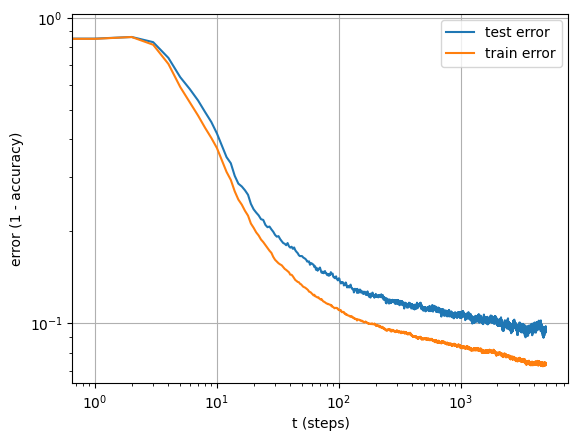

In [ ]:
plt.plot(test_loss,label="test error")
plt.plot(train_loss,label="train error")
plt.xlabel("t (steps)")
plt.ylabel("error (1 - accuracy)")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()